In [1]:
import pickle
M = 10
sample_range = [100, 200, 400]
x_train, _, x_test, _, _ = pickle.load(open('axis_aligned_data.pickle', 'rb'))

In [2]:
from Simulations.functions import *
from Mondrian_RF.Mondrian_forest import MondrianForestTransformer
from Mondrian_RF.utils import evaluate_all_lifetimes
from tqdm import tqdm

dim_in = 5
active = 2
tries = 10

x_train = x_train[:, :dim_in]
x_test = x_test[:, :dim_in]

fn = SimulatedData(dim_in, active, rotation="simple", fun="max")


y_train = vmap(fn.fun, in_axes=0, out_axes=0)(x_train)
y_test = vmap(fn.fun, in_axes=0, out_axes=0)(x_test)

In [3]:
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.01):
    res = jnp.dot(x, rotation)
    res = (res ** 2) * -0.25
    res = jnp.exp(res)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = 5 * jnp.max(res * projected, axis = 1)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y

In [4]:
fn.fun(x_train)

Array(5.1764054, dtype=float32)

In [5]:
true_H = fn.get_true_H(x_test)
true_H

Array([[0.74049664, 0.74049664, 0.74049664, 0.        , 0.        ],
       [0.74049664, 1.450081  , 0.74049664, 0.70958424, 0.7095843 ],
       [0.74049664, 0.74049664, 0.74049664, 0.        , 0.        ],
       [0.        , 0.70958424, 0.        , 0.70958424, 0.7095843 ],
       [0.        , 0.7095843 , 0.        , 0.7095843 , 0.7095843 ]],      dtype=float32)

# Save training history

In [6]:
lifetime = 5

# Mondrian Forest
forests = {}
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    forests[n_sim] = []
    for trial in tqdm(range(tries)):
        forest = MondrianForestTransformer(n_estimators=M, lifetime=lifetime, step_size=0.5, random_state=n_sim * (trial + 1))
        forest.fit(x_train[:n_sim], y_train[:n_sim])
        forests[n_sim].append(forest)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


# Get H estimate

In [7]:
H_est = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'H': []}
    for trial in range(tries):
        H_0 = forests[n_sim][trial].H
        dist['H'].append(H_0)
    H_est.append(dist)

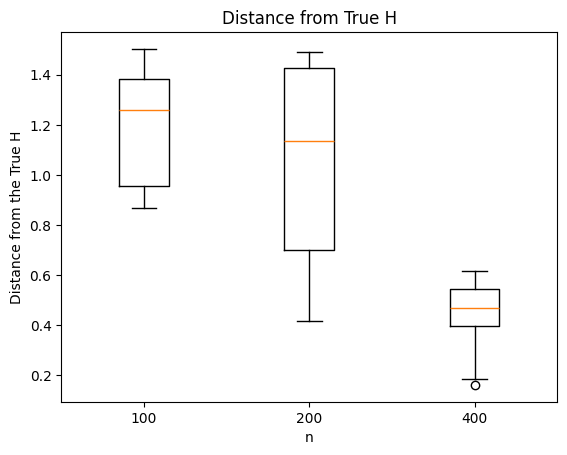

In [8]:
from util import get_angle_distance, plot_trend
def plot_dist(forests, title, true_H, norm_func, sample_range, active, tries = 10):
    plot_data = []
    for i in range(len(sample_range)):
        n_sim = sample_range[i]
        alter_dist = {'n': n_sim, 'dist':[]}
        for trial in range(tries):
            H_0 = forests[n_sim][trial].H
            alter_dist['dist'].append(norm_func(H_0, true_H, active))
        plot_data.append(alter_dist)
    plot_trend(plot_data, 'n', 'dist', title, ylabel='Distance from the True H')


def plot_H_estimates(forests, true_H, norm_func, sample_range, active):
    plot_dist(forests, 'Distance from True H', true_H, norm_func, sample_range, active)

plot_H_estimates(forests, true_H, get_angle_distance, sample_range, active)

In [9]:
results = []
results.append(
    evaluate_all_lifetimes(x_train[:n_sim,], 
                           y_train[:n_sim], 
                           x_test, y_test, M, lifetime))

In [10]:
from Mondrian_RF.utils import two_one_norm
x_train_transformed = np.matmul(x_train, true_H / two_one_norm(true_H))
x_test_transformed = np.matmul(x_test, true_H / two_one_norm(true_H))
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime))

In [11]:
x_train_transformed = forest.transform(x_train)
x_test_transformed = forest.transform(x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime))

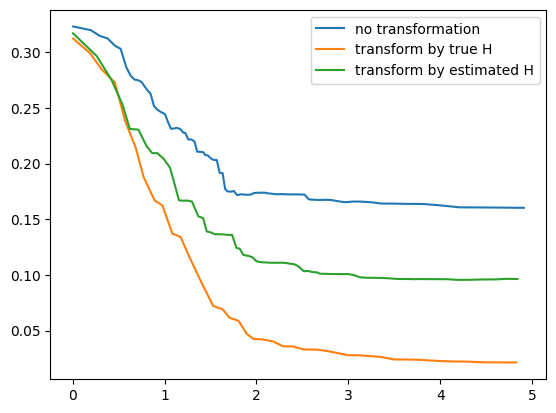

In [12]:
from matplotlib import pyplot as plt
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H')
plt.legend()

In [13]:
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    for trial in tqdm(range(tries)):
        forests[n_sim][trial].reiterate()

100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


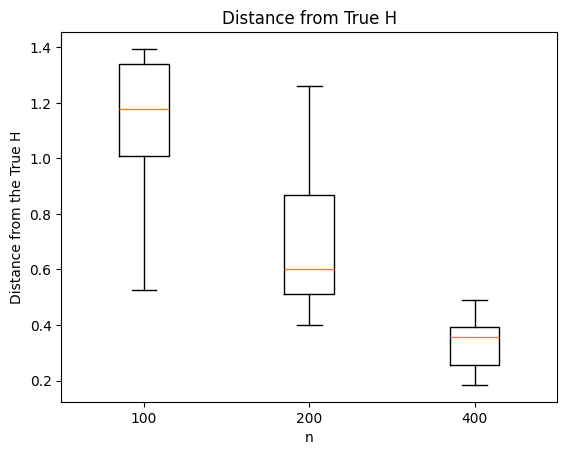

In [14]:
plot_H_estimates(forests, true_H, get_angle_distance, sample_range, active)

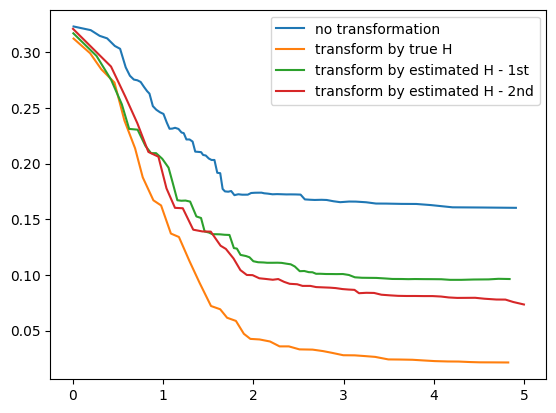

In [15]:
x_train_transformed = forest.transform(x_train)
x_test_transformed = forest.transform(x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime))

plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H - 1st')
plt.plot(results[3][0]['times'], results[3][0]['mse'], label = 'transform by estimated H - 2nd')
plt.legend()